In [123]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [124]:
import numpy as np
import pandas as pd

In [125]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [126]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [127]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [128]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
columns = inspector.get_columns('station')
print('-'*70)
for column in columns:
    print(column["name"], column["type"])

['measurement', 'station']

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------------------------------------------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [129]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [130]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [131]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [132]:
# Create our session (link) from Python to the DB
from sqlalchemy import desc
session = Session(engine)
last_date_dataset=session.query(Measurement.date).order_by(desc(Measurement.date)).all()[0][0]
last_date_dataset
##my planned trip:
start_date='2017-08-23'
end_date='2017-08-30'
start_date
end_date

'2017-08-23'

'2017-08-23'

'2017-08-30'

In [133]:
from flask import Flask, jsonify
results=session.query(Station.station,Station.name).all()

In [134]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#prcp_last12M=session.query(Measurement.station,Measurement.date,Measurement.prcp).filter(Measurement.date.between('2016-10-24',start_date)).all();

# Calculate the date 1 year ago from today
from dateutil.relativedelta import relativedelta
#we assume the current time is lats date in the dataset.
#If we choose now, there is no data in the past 12 months
current_time= (dt.datetime.strptime(last_date_dataset, '%Y-%m-%d')).strftime("%Y-%m-%d")
One_yrs_ago=(dt.datetime.strptime(last_date_dataset, '%Y-%m-%d')\
             - relativedelta(years=1)).strftime("%Y-%m-%d")
current_time
One_yrs_ago


# Perform a query to retrieve the data and precipitation scores
prcp_last12M=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date.between(One_yrs_ago,current_time)).all();


# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_last12M_df=pd.DataFrame(prcp_last12M)
# Sort the dataframe by date
prcp_last12M_df['date'] =pd.to_datetime(prcp_last12M_df['date'])
prcp_last12M_df.sort_values(by='date',inplace=True)
prcp_last12M_groupby=prcp_last12M_df.groupby('date').sum()

'2017-08-23'

'2016-08-23'

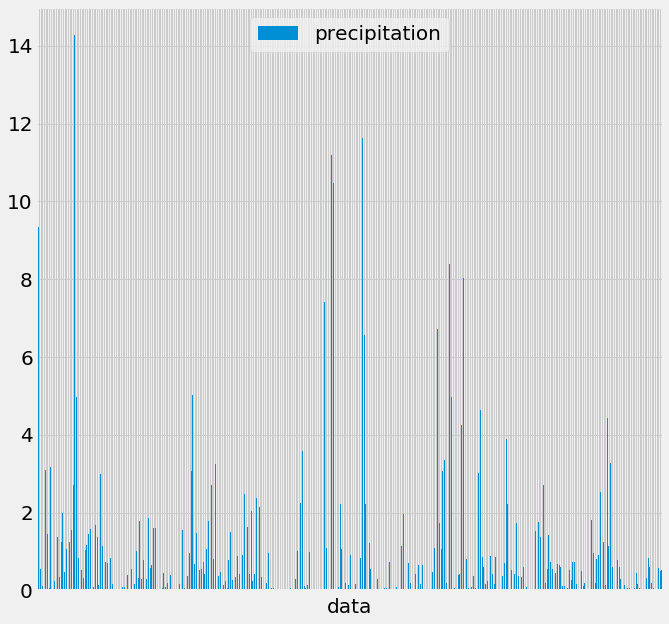

In [135]:
# Use Pandas Plotting with Matplotlib to plot the data
#%matplotlib notebook
ax=prcp_last12M_groupby.plot(kind='bar',figsize=(10,10),xticks=None,rot=90,use_index=True);
#https://stackoverflow.com/questions/20416609/remove-the-x-axis-ticks-while-keeping-the-grids-matplotlib
# ax.set_xticks(x_date, minor=True)
# ax.xaxis.grid(True, which='minor')
ax.grid(True)
#set_xdata(x_date)
_=ax.set_xticklabels([]);
_=ax.legend(['precipitation'],loc='upper center',fontsize=20);
_=plt.xlabel('data', fontsize=20);
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20) ;
# Rotate the xticks for the dates
#we  shall not use the dates for xticks because there are too many and the tick-labels will become messy

# Exploratory Climate Analysis

In [15]:
x_date=prcp_last12M_groupby.index.values[0:len(prcp_last12M_groupby.index.values):30]
x_date

array(['2016-08-23T00:00:00.000000000', '2016-09-22T00:00:00.000000000',
       '2016-10-22T00:00:00.000000000', '2016-11-21T00:00:00.000000000',
       '2016-12-21T00:00:00.000000000', '2017-01-20T00:00:00.000000000',
       '2017-02-19T00:00:00.000000000', '2017-03-21T00:00:00.000000000',
       '2017-04-20T00:00:00.000000000', '2017-05-20T00:00:00.000000000',
       '2017-06-19T00:00:00.000000000', '2017-07-19T00:00:00.000000000',
       '2017-08-18T00:00:00.000000000'], dtype='datetime64[ns]')

In [120]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_last12M_groupby.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [18]:
# How many stations are available in this dataset?
#method 1:
station_last12M=session.query(Measurement.station,Measurement.prcp).filter(Measurement.date.between(One_yrs_ago,current_time)).all();
station_last12M_df=pd.DataFrame(station_last12M)
len(station_last12M_df.groupby('station').count())
#method 2:
aa=session.query(Measurement.station,func.count(Measurement.prcp)).filter(Measurement.date.between(One_yrs_ago,current_time)).group_by(Measurement.station)
aa=aa.order_by(func.count(Measurement.prcp).desc()).all()
len(aa)

7

7

In [19]:
### What are the most active stations?
print(f"the most active three stations are:{[aa[i][0] for i in range(3)]}")
# List the stations and the counts in descending order.
aa

the most active three stations are:['USC00519397', 'USC00519281', 'USC00513117']


[('USC00519397', 359),
 ('USC00519281', 352),
 ('USC00513117', 343),
 ('USC00516128', 328),
 ('USC00519523', 314),
 ('USC00514830', 265),
 ('USC00517948', 60)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
print("the lowest temperature recorded for the three most active stations are:")
session.query(Measurement.station,func.min(Measurement.tobs)).\
filter(Measurement.date.between(One_yrs_ago,current_time)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.prcp).desc()).limit(3).all()

# highest temperature recorded, and average temperature most active station?
print("the hightest temperature recorded for the three most active stations are:")
session.query(Measurement.station,func.max(Measurement.tobs)).\
filter(Measurement.date.between(One_yrs_ago,current_time)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.prcp).desc()).limit(3).all()

# highest temperature recorded, and average temperature most active station?
print("the average temperature recorded for the three most active stations are:")
aa=session.query(Measurement.station,func.avg(Measurement.tobs)).\
filter(Measurement.date.between(One_yrs_ago,current_time)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.prcp).desc()).limit(3).all()
aa=[(aa[i][0],round(aa[i][1],2)) for i in range(len(aa))]
aa 

the lowest temperature recorded for the three most active stations are:


[('USC00519397', 60.0), ('USC00519281', 59.0), ('USC00513117', 61.0)]

the hightest temperature recorded for the three most active stations are:


[('USC00519397', 87.0), ('USC00519281', 83.0), ('USC00513117', 82.0)]

the average temperature recorded for the three most active stations are:


[('USC00519397', 75.21), ('USC00519281', 73.11), ('USC00513117', 73.28)]

In [23]:
aa=[(aa[i][0],round(aa[i][1],2)) for i in range(len(aa))]
aa                                         

[('USC00519397', 75.21), ('USC00519281', 73.11), ('USC00513117', 73.28)]

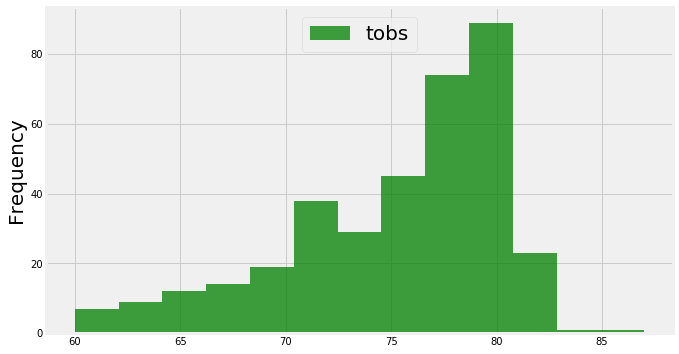

In [24]:
# Choose the station with the highest number of temperature observations.
aa=session.query(Measurement.station,func.count(Measurement.tobs)).\
filter(Measurement.date.between(One_yrs_ago,current_time)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()
aa
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
aa[0]

bb=pd.DataFrame(session.query(Measurement.station,Measurement.date,Measurement.tobs).\
filter(Measurement.date.between(One_yrs_ago,current_time)).\
filter_by(station=aa[0]).all())
bb.tobs.unique()
#order_by(func.count(Measurement.tobs).desc()).first()
fig=plt.figure(figsize=(10,6));
n, bins, patches=plt.hist(bb.tobs,13,facecolor='green', alpha=0.75);
plt.ylabel("Frequency",fontsize=20);
plt.legend(['tobs'],loc='upper center',fontsize=20);


In [25]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [119]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(f"The (min,average,max) temperature  during the last year's same dates as my planned trip_dates from {start_date} to {end_date}: \n {calc_temps(start_date, end_date)[0]}")


The (min,average,max) temperature  during the last year's same dates as my planned trip_dates from 2017-08-23 to 2017-08-30: 
 (76.0, 80.25, 82.0)


Whcih, plotted in a bar char to visualize, is as follows,


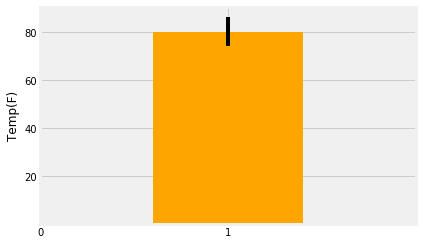

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
print("Whcih, plotted in a bar char to visualize, is as follows,")
aa=calc_temps(start_date, end_date)[0];
plt.bar(1, aa[1], yerr=aa[2]-aa[0],width=0.8,color='orange');
plt.xlim((0, 2));
plt.xticks(np.arange(0, 2, step=1));
plt.yticks([20,40,60,80]);
plt.ylabel('Temp(F)');

In [34]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
aa=session.query(Measurement,Station,func.sum(Measurement.prcp)).\
filter(Measurement.date.between(start_date,end_date)).\
filter(Measurement.station==Station.station).\
group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).all()
for row in aa:
    print(row[0].station,row[1].name,row[1].latitude,row[1].longitude,row[1].elevation,row[2])

USC00516128 MANOA LYON ARBO 785.2, HI US 21.3331 -157.8025 152.4 0.45
USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 21.33556 -157.71139 19.5 0.08
USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 21.5213 -157.8374 7.0 0.0
USC00519397 WAIKIKI 717.2, HI US 21.2716 -157.8168 3.0 0.0


In [33]:
start_date
end_date

'2017-08-23'

'2017-08-30'

In [35]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

aa=session.query(Measurement,Station,func.sum(Measurement.prcp)).\
filter(Measurement.date.between(start_date,end_date)).\
filter(Measurement.station==Station.station).\
group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).all()
for row in aa:
    print(row[0].station,row[1].name,row[1].latitude,row[1].longitude,row[1].elevation,row[2])

USC00516128 MANOA LYON ARBO 785.2, HI US 21.3331 -157.8025 152.4 0.45
USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 21.33556 -157.71139 19.5 0.08
USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 21.5213 -157.8374 7.0 0.0
USC00519397 WAIKIKI 717.2, HI US 21.2716 -157.8168 3.0 0.0


In [ ]:
columns = inspector.get_columns('Station')
print('-'*70)
for column in columns:
    print(column["name"], column["type"])
session.query(Station.station,Station.name,Station.latitude, Station.longitude, Station.elevation).all()

## Optional Challenge Assignment

In [36]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
    
daily_normals("01-01")



[(62.0, 69.15384615384616, 77.0)]

In [116]:
start_date
end_date
# mydates = pd.date_range(start_date, end_date).tolist()
# mydates=[mydates[i].strftime('%m-%d') for i in range(len(mydates))]
# mydates

'2017-08-23'

'2017-08-30'

In [54]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
    
# Set the start and end date of the trip
start_date
end_date
# Use the start and end date to create a range of dates
mydates = pd.date_range(start_date, end_date).tolist()
# Stip off the year and save a list of %m-%d strings
mydates=[mydates[i].strftime('%m-%d') for i in range(len(mydates))]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for date in mydates:  
    normals.append(daily_normals(date)[0])
normals


[(67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0)]

In [67]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
mydates
temp_df=pd.DataFrame([list(normals[i]) for i in range(len(normals))],\
             index=mydates,columns=['min','avg','max'])
temp_df

['08-23', '08-24', '08-25', '08-26', '08-27', '08-28', '08-29', '08-30']

,min,avg,max
08-23,67.0,76.692308,87.0
08-24,70.0,75.961538,84.0
08-25,69.0,76.960784,82.0
08-26,71.0,76.568627,84.0
08-27,68.0,76.283019,84.0
08-28,67.0,76.734694,86.0
08-29,70.0,76.235294,85.0
08-30,68.0,76.416667,84.0


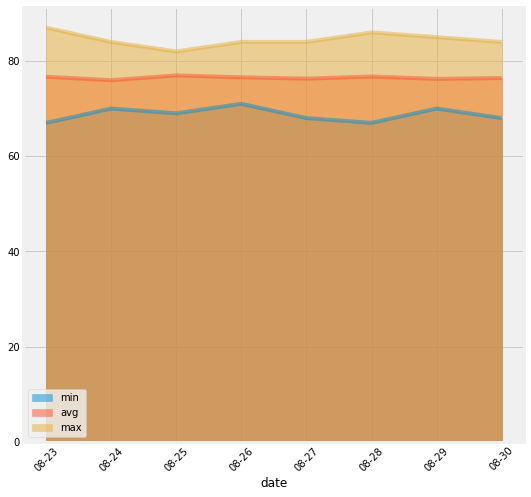

In [115]:
ax=temp_df.plot.area(stacked=False,figsize=(8,8),grid =True);

fig_size = plt.rcParams["figure.figsize"]
plt.xlabel('date');
locs, labels = plt.xticks();
plt.xticks(locs[1:len(locs)-1], mydates,rotation=45);
